In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 5
commitnumber = d62b618
conc = 0.0004
dv = 0.005
klin = 0
molecule = co2
ng_adju = [0, 0]
ng_refs = [8, 8]
nv = 200
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (500, 250)]
tsfc = 294
vmax = 1100
vmin = 980
w_diffuse = [(1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66), (1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66)]
wgt = [(1, 1, 1, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 1)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

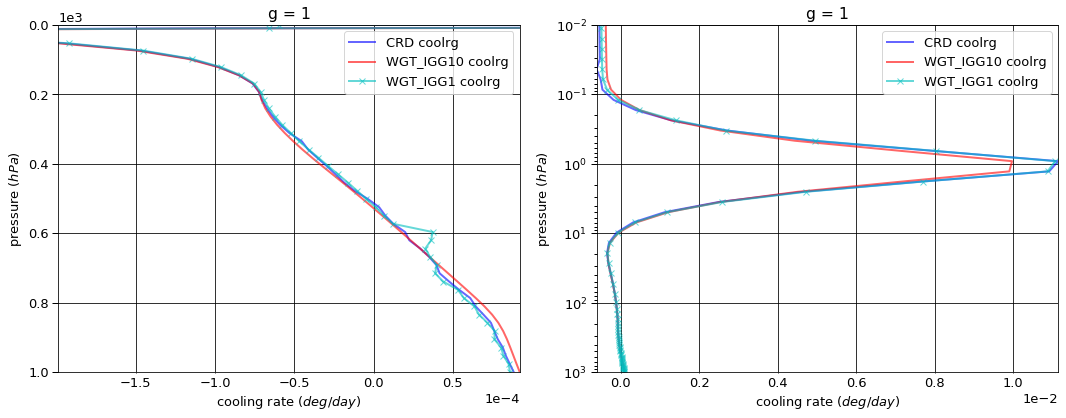

# Figure: cooling rate g-group 2

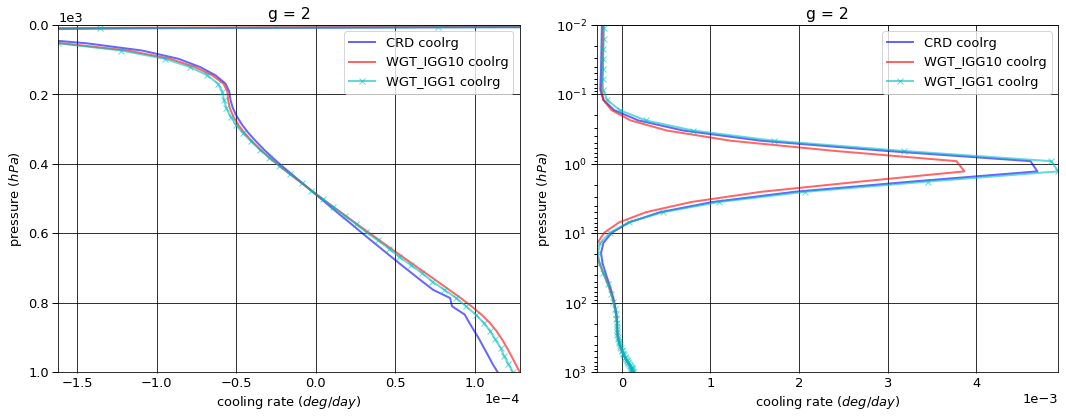

# Figure: cooling rate g-group 3

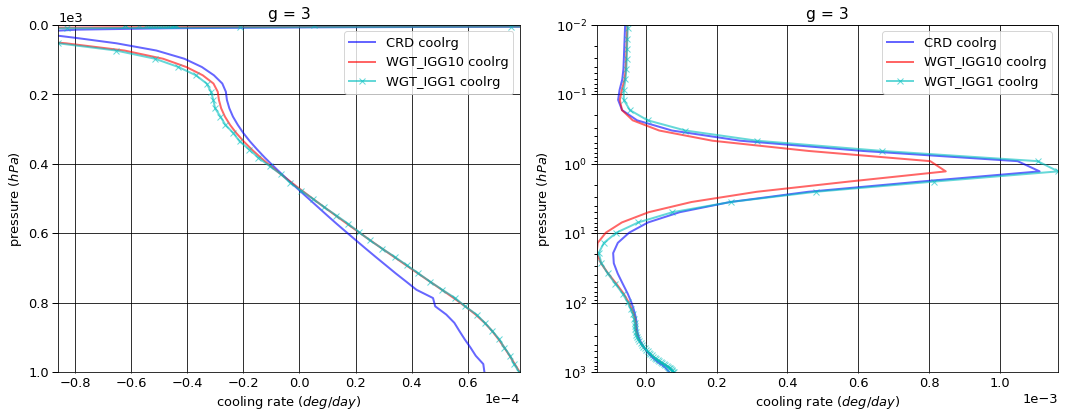

# Figure: cooling rate g-group 4

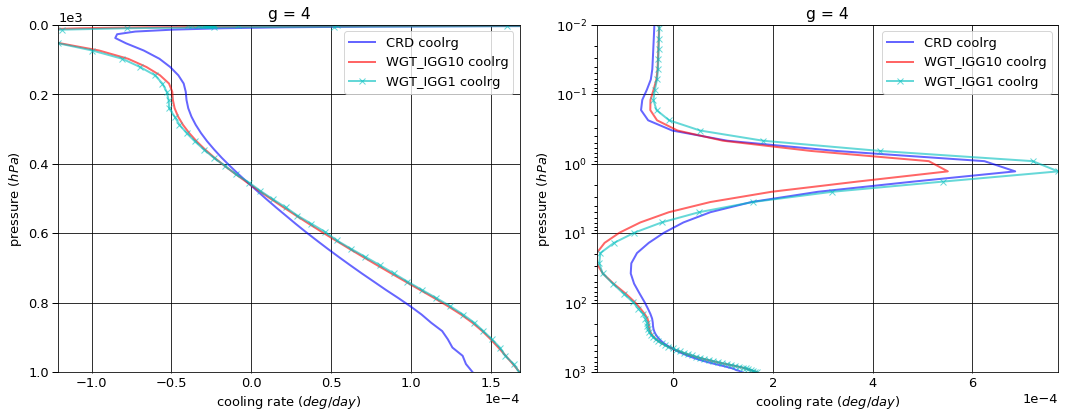

# Figure: cooling rate g-group 5

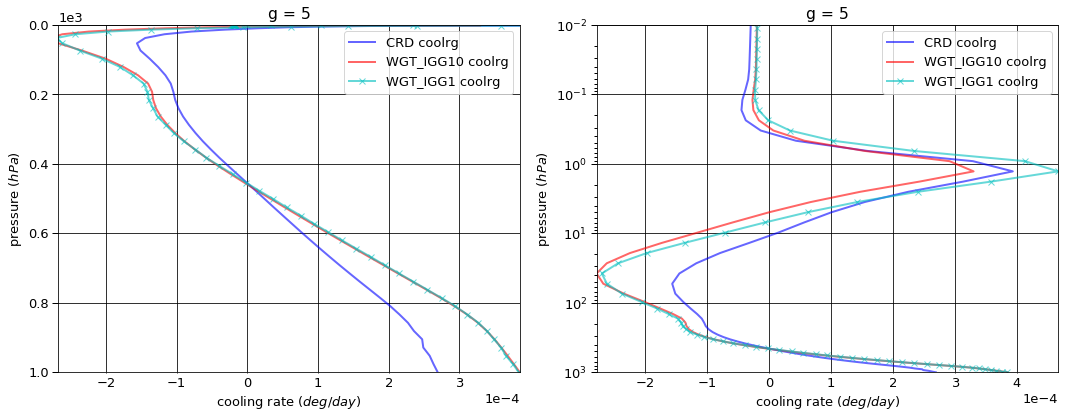

# Figure: cooling rate g-group 6

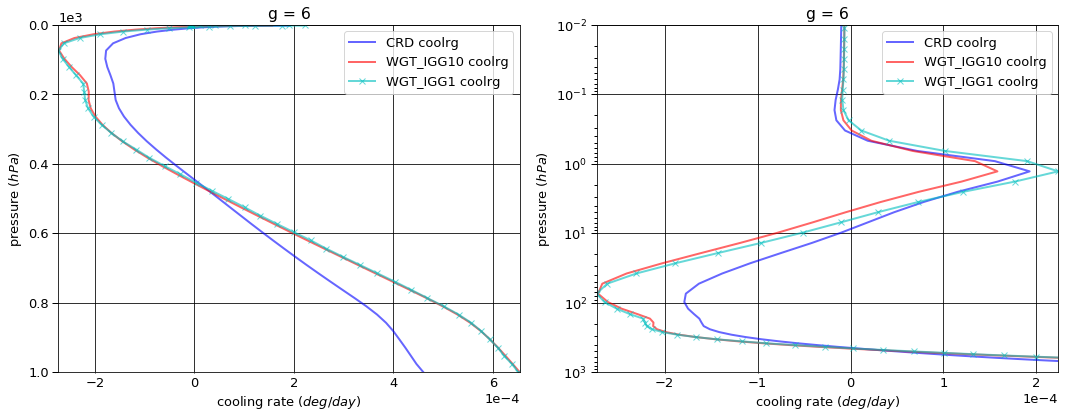

# Figure: cooling rate g-group 7

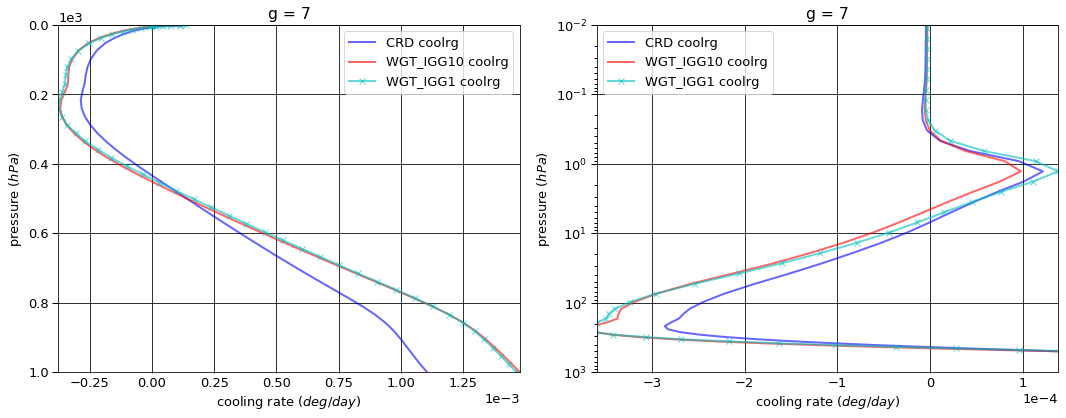

# Figure: cooling rate g-group 8

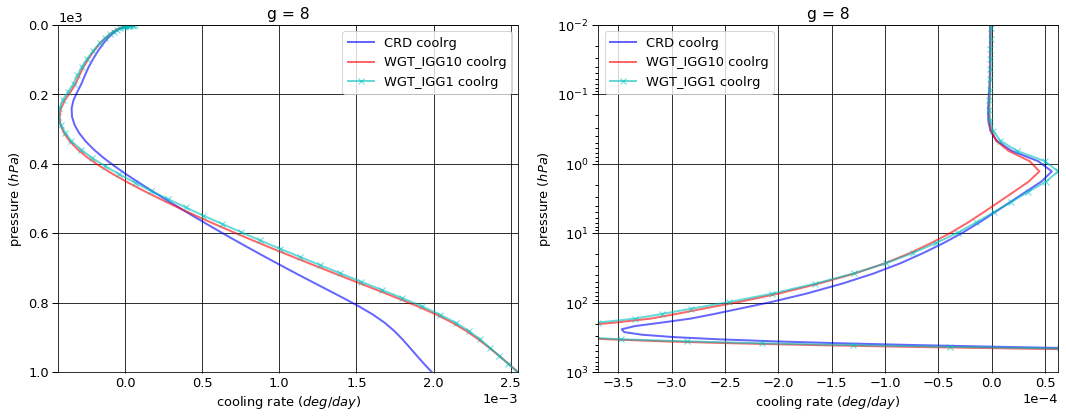

# Figure: cooling rate g-group 9

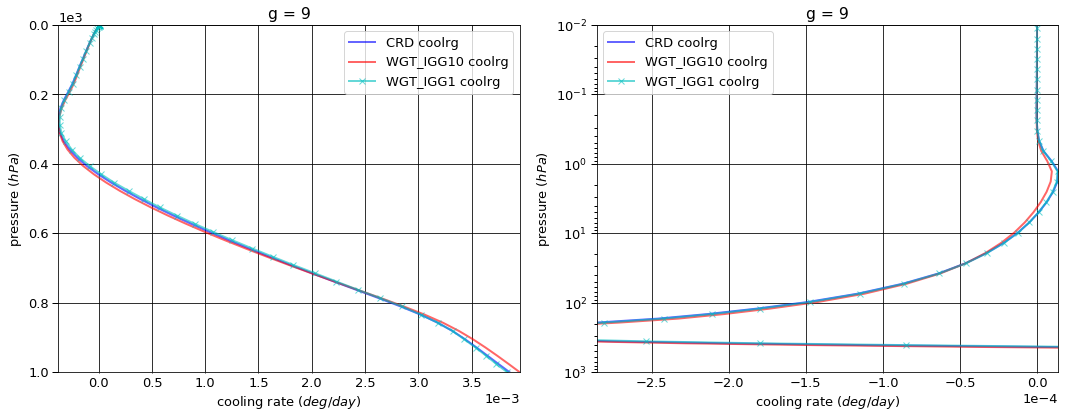

# Figure: cooling rate g-group 10

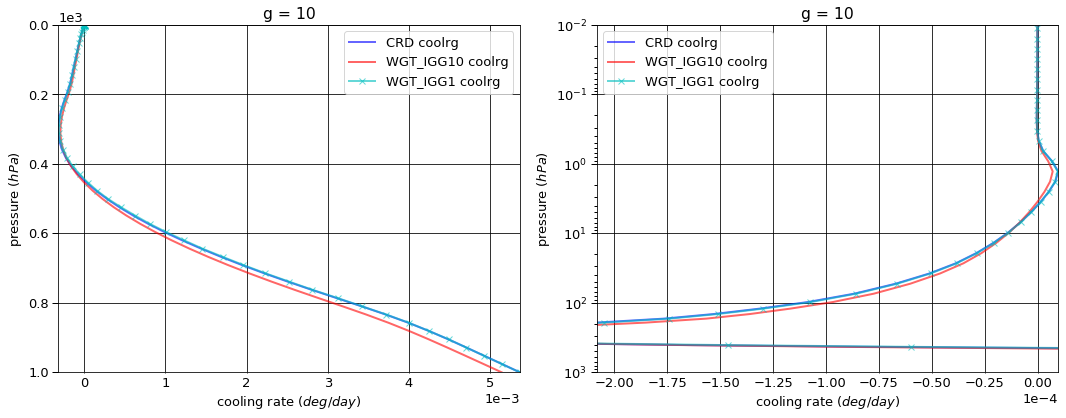

# Figure: cooling rate g-group 11

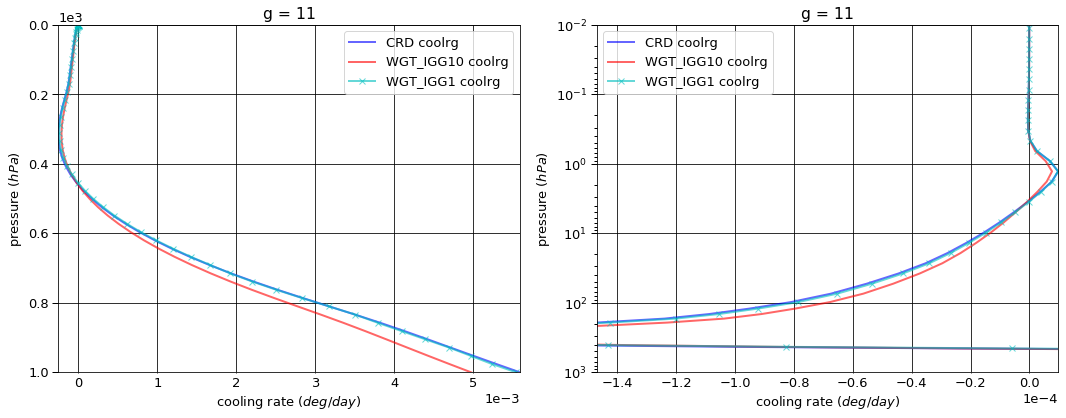

# Figure: cooling rate g-group 12

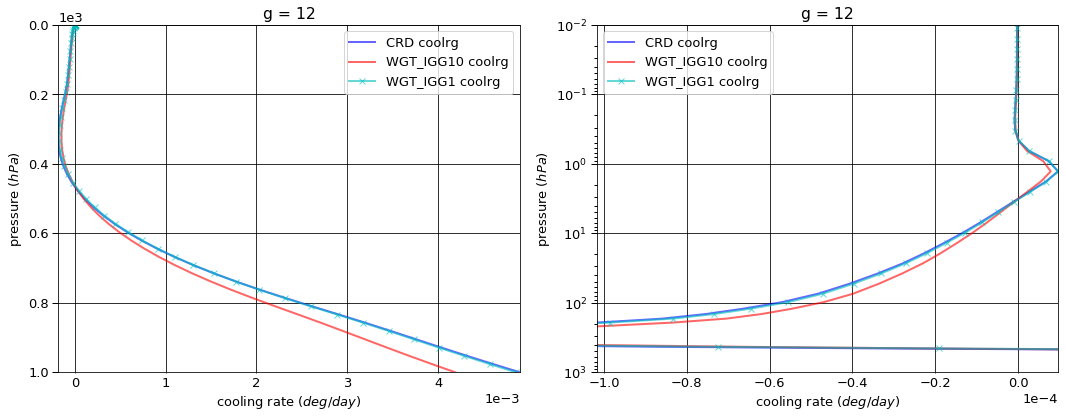

# Figure: cooling rate g-group 13

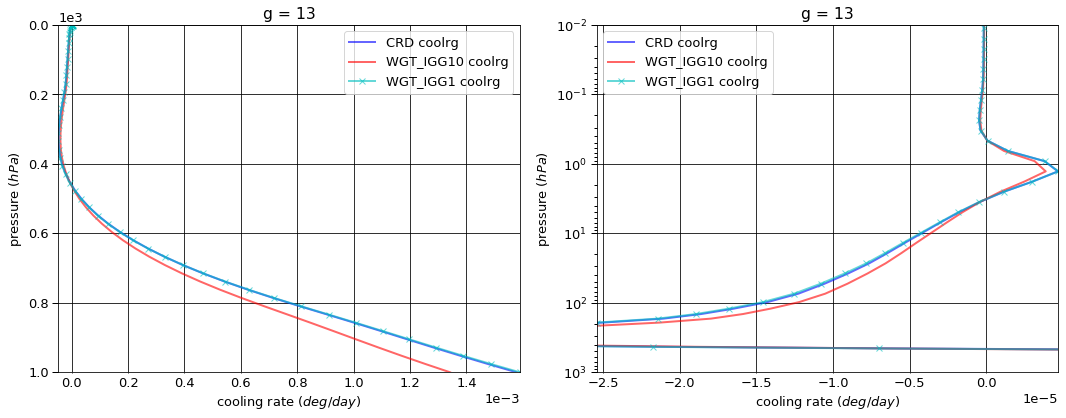

# Figure: cooling rate g-group 14

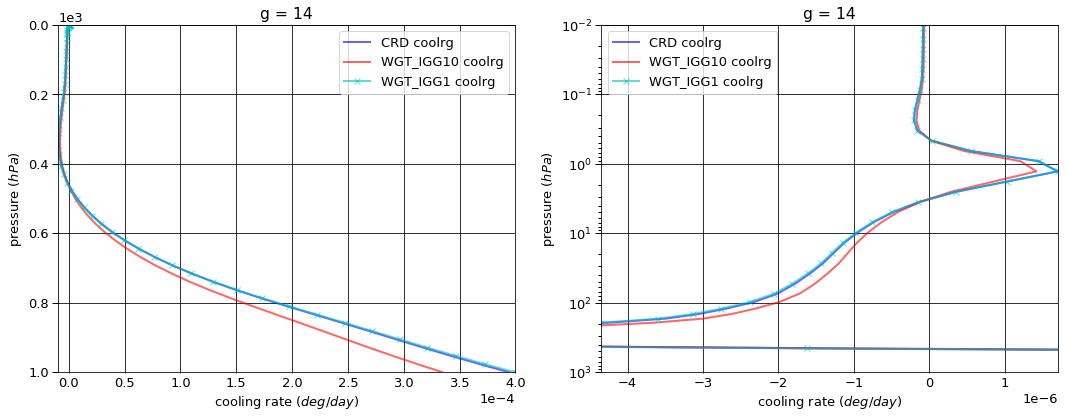

# Figure: cooling rate g-group 15

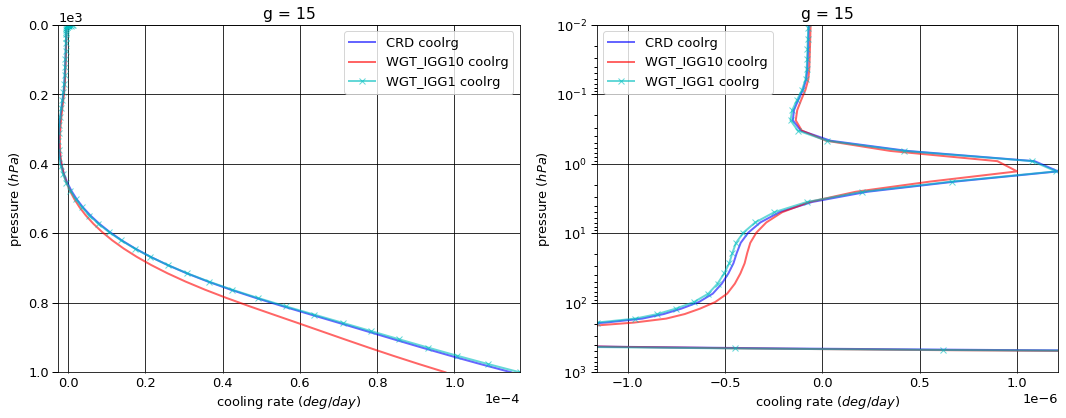

# Figure: cooling rate g-group 16

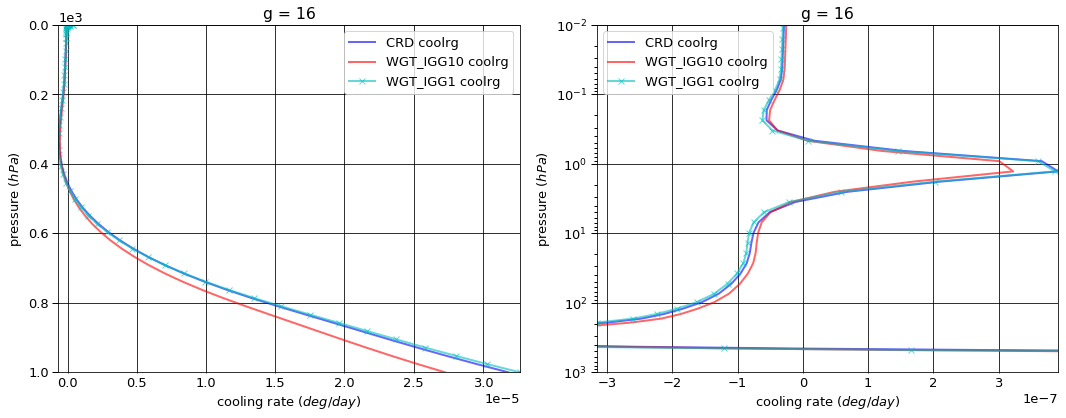

# Figure: cooling rate g-group total

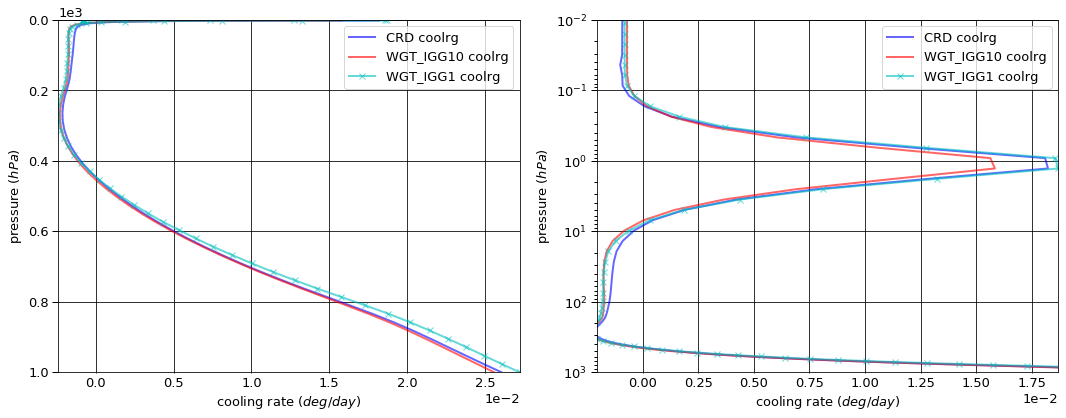

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.008085  0.000000 -0.008085
   1013.0   76    -0.016067  0.009248 -0.006820
2  0.0      1     -0.017975  0.000000 -0.017975
   1013.0   76    -0.026174  0.010010 -0.016164
3  0.0      1     -0.018545  0.000000 -0.018545
   1013.0   76    -0.022670  0.005175 -0.017495
4  0.0      1     -0.039494  0.000000 -0.039494
   1013.0   76    -0.046111  0.009563 -0.036549
5  0.0      1     -0.088647  0.000000 -0.088647
   1013.0   76    -0.103924  0.020714 -0.083210
6  0.0      1     -0.151947  0.000000 -0.151947
   1013.0   76    -0.175654  0.034569 -0.141085
7  0.0      1     -0.316484  0.000000 -0.316484
   1013.0   76    -0.363701  0.079188 -0.284513
8  0.0      1     -0.564321  0.000000 -0.564321
   1013.0   76    -0.630565  0.130830 -0.499735
9  0.0      1     -0.594379  0.000000 -0.594379
   1013.0   76    -0.682617  0.217099 -0.465518
10 0.0      1     -1.472556  0.000000 -1.472556
   1013.0   76    -1.551907  0.238991 -1.312917
11 0.0      1     -3.551224  0.000000 -3.551224
   1013.0   76    -3.614927  0.215615 -3.399312
12 0.0      1     -7.632350  0.000000 -7.632350
   1013.0   76    -7.680450  0.175223 -7.505226
13 0.0      1     -6.084044  0.000000 -6.084044
   1013.0   76    -6.097662  0.053839 -6.043823
14 0.0      1     -4.054790  0.000000 -4.054790
   1013.0   76    -4.057785  0.012868 -4.044917
15 0.0      1     -3.396752  0.000000 -3.396752
   1013.0   76    -3.397573  0.003652 -3.393921
16 0.0      1     -2.886231  0.000000 -2.886231
   1013.0   76    -2.886450  0.000998 -2.885451


WGT_IGG10


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.007524  0.000000 -0.007524
   1013.0   76    -0.015680  0.009391 -0.006289
2  0.0      1     -0.017361  0.000000 -0.017361
   1013.0   76    -0.026190  0.010585 -0.015606
3  0.0      1     -0.017657  0.000000 -0.017657
   1013.0   76    -0.022326  0.005741 -0.016585
4  0.0      1     -0.037498  0.000000 -0.037498
   1013.0   76    -0.045190  0.010897 -0.034293
5  0.0      1     -0.083944  0.000000 -0.083944
   1013.0   76    -0.102577  0.026057 -0.076520
6  0.0      1     -0.145131  0.000000 -0.145131
   1013.0   76    -0.173219  0.043229 -0.129990
7  0.0      1     -0.306348  0.000000 -0.306348
   1013.0   76    -0.358484  0.093438 -0.265046
8  0.0      1     -0.553809  0.000000 -0.553809
   1013.0   76    -0.622796  0.147824 -0.474973
9  0.0      1     -0.588657  0.000000 -0.588657
   1013.0   76    -0.669513  0.210170 -0.459343
10 0.0      1     -1.459935  0.000000 -1.459935
   1013.0   76    -1.529322  0.218424 -1.310897
11 0.0      1     -3.501151  0.000000 -3.501151
   1013.0   76    -3.554465  0.186848 -3.367617
12 0.0      1     -7.529855  0.000000 -7.529855
   1013.0   76    -7.569374  0.147739 -7.421635
13 0.0      1     -6.117735  0.000000 -6.117735
   1013.0   76    -6.129244  0.045458 -6.083786
14 0.0      1     -4.106922  0.000000 -4.106922
   1013.0   76    -4.109480  0.010874 -4.098606
15 0.0      1     -3.462509  0.000000 -3.462509
   1013.0   76    -3.463218  0.003097 -3.460121
16 0.0      1     -2.962968  0.000000 -2.962968
   1013.0   76    -2.963160  0.000851 -2.962309


WGT_IGG1


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.007879  0.000000 -0.007879
   1013.0   76    -0.015680  0.009242 -0.006438
2  0.0      1     -0.017455  0.000000 -0.017455
   1013.0   76    -0.026190  0.010641 -0.015549
3  0.0      1     -0.017476  0.000000 -0.017476
   1013.0   76    -0.022326  0.005981 -0.016346
4  0.0      1     -0.037043  0.000000 -0.037043
   1013.0   76    -0.045190  0.011436 -0.033755
5  0.0      1     -0.082881  0.000000 -0.082881
   1013.0   76    -0.102577  0.027239 -0.075338
6  0.0      1     -0.143319  0.000000 -0.143319
   1013.0   76    -0.173219  0.045279 -0.127940
7  0.0      1     -0.302780  0.000000 -0.302780
   1013.0   76    -0.358484  0.097629 -0.260855
8  0.0      1     -0.548169  0.000000 -0.548169
   1013.0   76    -0.622796  0.155721 -0.467076
9  0.0      1     -0.583113  0.000000 -0.583113
   1013.0   76    -0.669513  0.216826 -0.452687
10 0.0      1     -1.451372  0.000000 -1.451372
   1013.0   76    -1.529322  0.238724 -1.290598
11 0.0      1     -3.492405  0.000000 -3.492405
   1013.0   76    -3.554465  0.214014 -3.340451
12 0.0      1     -7.522514  0.000000 -7.522514
   1013.0   76    -7.569374  0.173847 -7.395527
13 0.0      1     -6.115503  0.000000 -6.115503
   1013.0   76    -6.129244  0.054121 -6.075123
14 0.0      1     -4.106418  0.000000 -4.106418
   1013.0   76    -4.109480  0.013004 -4.096475
15 0.0      1     -3.462368  0.000000 -3.462368
   1013.0   76    -3.463218  0.003709 -3.459508
16 0.0      1     -2.962930  0.000000 -2.962930
   1013.0   76    -2.963160  0.001020 -2.962140


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000561  0.000000  0.000561
   1013.0   76     0.000388  0.000144  0.000531
2  0.0      1      0.000614  0.000000  0.000614
   1013.0   76    -0.000017  0.000575  0.000558
3  0.0      1      0.000888  0.000000  0.000888
   1013.0   76     0.000344  0.000566  0.000910
4  0.0      1      0.001996  0.000000  0.001996
   1013.0   76     0.000921  0.001335  0.002256
5  0.0      1      0.004703  0.000000  0.004703
   1013.0   76     0.001347  0.005343  0.006691
6  0.0      1      0.006816  0.000000  0.006816
   1013.0   76     0.002436  0.008660  0.011095
7  0.0      1      0.010136  0.000000  0.010136
   1013.0   76     0.005217  0.014250  0.019467
8  0.0      1      0.010511  0.000000  0.010511
   1013.0   76     0.007768  0.016994  0.024762
9  0.0      1      0.005722  0.000000  0.005722
   1013.0   76     0.013104 -0.006929  0.006176
10 0.0      1      0.012621  0.000000  0.012621
   1013.0   76     0.022586 -0.020566  0.002019
11 0.0      1      0.050073  0.000000  0.050073
   1013.0   76     0.060462 -0.028767  0.031695
12 0.0      1      0.102495  0.000000  0.102495
   1013.0   76     0.111075 -0.027484  0.083591
13 0.0      1     -0.033691  0.000000 -0.033691
   1013.0   76    -0.031582 -0.008381 -0.039963
14 0.0      1     -0.052132  0.000000 -0.052132
   1013.0   76    -0.051695 -0.001994 -0.053689
15 0.0      1     -0.065757  0.000000 -0.065757
   1013.0   76    -0.065644 -0.000556 -0.066200
16 0.0      1     -0.076737  0.000000 -0.076737
   1013.0   76    -0.076710 -0.000148 -0.076857


WGT_IGG1 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000206  0.000000  0.000206
   1013.0   76     0.000388 -0.000006  0.000382
2  0.0      1      0.000520  0.000000  0.000520
   1013.0   76    -0.000017  0.000631  0.000614
3  0.0      1      0.001069  0.000000  0.001069
   1013.0   76     0.000344  0.000806  0.001149
4  0.0      1      0.002451  0.000000  0.002451
   1013.0   76     0.000921  0.001873  0.002794
5  0.0      1      0.005766  0.000000  0.005766
   1013.0   76     0.001347  0.006525  0.007872
6  0.0      1      0.008628  0.000000  0.008628
   1013.0   76     0.002436  0.010710  0.013146
7  0.0      1      0.013705  0.000000  0.013705
   1013.0   76     0.005217  0.018441  0.023658
8  0.0      1      0.016151  0.000000  0.016151
   1013.0   76     0.007768  0.024891  0.032659
9  0.0      1      0.011266  0.000000  0.011266
   1013.0   76     0.013104 -0.000272  0.012832
10 0.0      1      0.021184  0.000000  0.021184
   1013.0   76     0.022586 -0.000267  0.022319
11 0.0      1      0.058819  0.000000  0.058819
   1013.0   76     0.060462 -0.001601  0.058861
12 0.0      1      0.109836  0.000000  0.109836
   1013.0   76     0.111075 -0.001376  0.109699
13 0.0      1     -0.031459  0.000000 -0.031459
   1013.0   76    -0.031582  0.000282 -0.031300
14 0.0      1     -0.051627  0.000000 -0.051627
   1013.0   76    -0.051695  0.000137 -0.051558
15 0.0      1     -0.065617  0.000000 -0.065617
   1013.0   76    -0.065644  0.000057 -0.065587
16 0.0      1     -0.076699  0.000000 -0.076699
   1013.0   76    -0.076710  0.000021 -0.076689

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1     -5.437661e-04
   1001.112500 75     8.844087e-05
2  0.000312    1     -2.028481e-04
   1001.112500 75     1.142608e-04
3  0.000312    1     -4.968884e-05
   1001.112500 75     6.598032e-05
4  0.000312    1     -3.088044e-05
   1001.112500 75     1.388457e-04
5  0.000312    1     -2.541301e-05
   1001.112500 75     2.692214e-04
6  0.000312    1     -8.350552e-06
   1001.112500 75     4.606901e-04
7  0.000312    1     -3.538753e-06
   1001.112500 75     1.105012e-03
8  0.000312    1     -1.247673e-06
   1001.112500 75     1.989461e-03
9  0.000312    1     -5.772919e-09
   1001.112500 75     3.858501e-03
10 0.000312    1     -2.563440e-08
   1001.112500 75     5.370134e-03
11 0.000312    1     -7.249321e-08
   1001.112500 75     5.588965e-03
12 0.000312    1     -1.626624e-07
   1001.112500 75     4.898961e-03
13 0.000312    1     -1.249448e-07
   1001.112500 75     1.577845e-03
14 0.000312    1     -6.543242e-08
   1001.112500 75     3.944435e-04
15 0.000312    1     -5.708675e-08
   1001.112500 75     1.147044e-04
16 0.000312    1     -2.418442e-08
   1001.112500 75     3.183496e-05


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1     -3.910588e-04
   1001.112500 75     9.222835e-05
2  0.000312    1     -1.846224e-04
   1001.112500 75     1.281049e-04
3  0.000312    1     -4.415010e-05
   1001.112500 75     7.859632e-05
4  0.000312    1     -2.316658e-05
   1001.112500 75     1.683804e-04
5  0.000312    1     -1.714514e-05
   1001.112500 75     3.853688e-04
6  0.000312    1     -5.594058e-06
   1001.112500 75     6.544150e-04
7  0.000312    1     -2.398449e-06
   1001.112500 75     1.477492e-03
8  0.000312    1     -9.247913e-07
   1001.112500 75     2.548781e-03
9  0.000312    1     -5.149996e-09
   1001.112500 75     3.953646e-03
10 0.000312    1     -2.196291e-08
   1001.112500 75     5.145490e-03
11 0.000312    1     -5.939832e-08
   1001.112500 75     4.971669e-03
12 0.000312    1     -1.322698e-07
   1001.112500 75     4.188051e-03
13 0.000312    1     -1.028978e-07
   1001.112500 75     1.342178e-03
14 0.000312    1     -5.296796e-08
   1001.112500 75     3.349142e-04
15 0.000312    1     -4.957565e-08
   1001.112500 75     9.768159e-05
16 0.000312    1     -2.120640e-08
   1001.112500 75     2.726543e-05


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1     -4.991800e-04
   1001.112500 75     8.604120e-05
2  0.000312    1     -1.871233e-04
   1001.112500 75     1.236903e-04
3  0.000312    1     -4.394001e-05
   1001.112500 75     7.846790e-05
4  0.000312    1     -2.313869e-05
   1001.112500 75     1.681229e-04
5  0.000312    1     -1.679918e-05
   1001.112500 75     3.838456e-04
6  0.000312    1     -5.561385e-06
   1001.112500 75     6.515160e-04
7  0.000312    1     -2.420991e-06
   1001.112500 75     1.464865e-03
8  0.000312    1     -9.659807e-07
   1001.112500 75     2.545405e-03
9  0.000312    1     -5.382654e-09
   1001.112500 75     3.836253e-03
10 0.000312    1     -2.448462e-08
   1001.112500 75     5.368026e-03
11 0.000312    1     -6.893880e-08
   1001.112500 75     5.541336e-03
12 0.000312    1     -1.566103e-07
   1001.112500 75     4.855239e-03
13 0.000312    1     -1.227353e-07
   1001.112500 75     1.589441e-03
14 0.000312    1     -6.341505e-08
   1001.112500 75     3.997709e-04
15 0.000312    1     -5.941633e-08
   1001.112500 75     1.169312e-04
16 0.000312    1     -2.540925e-08
   1001.112500 75     3.267054e-05


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.527072e-04
   1001.112500 75     3.787481e-06
2  0.000312    1      1.822564e-05
   1001.112500 75     1.384406e-05
3  0.000312    1      5.538735e-06
   1001.112500 75     1.261600e-05
4  0.000312    1      7.713855e-06
   1001.112500 75     2.953466e-05
5  0.000312    1      8.267869e-06
   1001.112500 75     1.161474e-04
6  0.000312    1      2.756494e-06
   1001.112500 75     1.937249e-04
7  0.000312    1      1.140304e-06
   1001.112500 75     3.724803e-04
8  0.000312    1      3.228812e-07
   1001.112500 75     5.593207e-04
9  0.000312    1      6.229228e-10
   1001.112500 75     9.514500e-05
10 0.000312    1      3.671493e-09
   1001.112500 75    -2.246445e-04
11 0.000312    1      1.309489e-08
   1001.112500 75    -6.172954e-04
12 0.000312    1      3.039263e-08
   1001.112500 75    -7.109095e-04
13 0.000312    1      2.204697e-08
   1001.112500 75    -2.356671e-04
14 0.000312    1      1.246446e-08
   1001.112500 75    -5.952926e-05
15 0.000312    1      7.511099e-09
   1001.112500 75    -1.702278e-05
16 0.000312    1      2.978021e-09
   1001.112500 75    -4.569532e-06


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      4.458608e-05
   1001.112500 75    -2.399672e-06
2  0.000312    1      1.572480e-05
   1001.112500 75     9.429470e-06
3  0.000312    1      5.748825e-06
   1001.112500 75     1.248758e-05
4  0.000312    1      7.741750e-06
   1001.112500 75     2.927721e-05
5  0.000312    1      8.613836e-06
   1001.112500 75     1.146242e-04
6  0.000312    1      2.789166e-06
   1001.112500 75     1.908259e-04
7  0.000312    1      1.117762e-06
   1001.112500 75     3.598534e-04
8  0.000312    1      2.816918e-07
   1001.112500 75     5.559446e-04
9  0.000312    1      3.902649e-10
   1001.112500 75    -2.224750e-05
10 0.000312    1      1.149781e-09
   1001.112500 75    -2.108100e-06
11 0.000312    1      3.554413e-09
   1001.112500 75    -4.762910e-05
12 0.000312    1      6.052110e-09
   1001.112500 75    -4.372120e-05
13 0.000312    1      2.209500e-09
   1001.112500 75     1.159550e-05
14 0.000312    1      2.017370e-09
   1001.112500 75     5.327470e-06
15 0.000312    1     -2.329582e-09
   1001.112500 75     2.226800e-06
16 0.000312    1     -1.224832e-09
   1001.112500 75     8.355810e-07

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.877825,0.00000,-30.877825
1013.0,76,-31.354237,1.21758,-30.136657



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.899004,0.000000,-30.899004
1013.0,76,-31.354237,1.170623,-30.183614



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.853624,0.000000,-30.853624
1013.0,76,-31.354237,1.278432,-30.075805



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-2.117928e-02,0.000000,-0.021179
1013.0,76,-1.830000e-07,-0.046958,-0.046958



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.420099e-02,0.000000,0.024201
1013.0,76,-1.830000e-07,0.060852,0.060852


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000866
1001.112500,75,0.026067



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000670
1001.112500,75,0.025594



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000780
1001.112500,75,0.027242



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000197
1001.112500,75,-0.000473



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000087
1001.112500,75,0.001174


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000542,0.000500
2,0.000833,0.000835
3,0.000750,0.000712
4,0.001542,0.001441
5,0.003417,0.003272
6,0.005792,0.005525
7,0.012000,0.011433
8,0.020708,0.019863
9,0.022750,0.021353


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.625183e-21
2,4.593142e-22
3,1.298128e-22
4,3.668809e-23
5,1.036890e-23
6,2.930491e-24
7,8.282244e-25
8,2.340754e-25
9,1.618833e-23


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.625183e-21,NaN,0.000542,0.000500,0.000542,0.000500,1.0
2,4.593142e-22,0.282623,0.000833,0.000835,0.001375,0.001335,1.0
3,1.298128e-22,0.282623,0.000750,0.000712,0.002125,0.002047,1.0
4,3.668809e-23,0.282623,0.001542,0.001441,0.003667,0.003489,1.0
5,1.036890e-23,0.282623,0.003417,0.003272,0.007083,0.006760,1.0
6,2.930491e-24,0.282623,0.005792,0.005525,0.012875,0.012285,1.0
7,8.282244e-25,0.282623,0.012000,0.011433,0.024875,0.023718,1.0
8,2.340754e-25,0.282623,0.020708,0.019863,0.045583,0.043581,1.0
9,1.618833e-23,69.158615,0.022750,0.021353,0.068333,0.064935,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
